In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from skimage.feature import hog, canny
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
#from skimage import data
#from skimage.measure import moments_zernike
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import mahotas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
df = pd.read_csv('data/sample_submission.csv')

In [5]:
df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [6]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Check for missing values
train_df.isnull().sum().sum()
test_df.isnull().sum().sum()

0

In [11]:
# Separate features and labels
X = train_df.drop(columns=['label']).values
y = train_df['label'].values

In [7]:
# Assuming the last column is the label and the rest are pixel intensities
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.values

# Check the shapes of the data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)

# Reshape images (assuming 28x28 for MNIST-like data)
X_train_images = X_train.reshape(-1, 28, 28)
X_test_images = X_test.reshape(-1, 28, 28)

print("Shape of X_train_images:", X_train_images.shape)
print("Shape of X_test_images:", X_test_images.shape)

Shape of X_train: (42000, 784)
Shape of y_train: (42000,)
Shape of X_test: (28000, 784)
Shape of X_train_images: (42000, 28, 28)
Shape of X_test_images: (28000, 28, 28)


In [8]:
# Feature extraction function
def extract_features(image):
    # Normalize the pixel values
    image = (image / 255.0).astype(np.float32)
    
    # Flatten pixel intensities
    pixel_intensity = image.flatten()

    # HOG features
    hog_features, _ = hog(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)

    # Edge detection
    edges = canny(image).flatten()

    # Corner detection
    corners = cv2.goodFeaturesToTrack(image, 25, 0.01, 10)
    corner_features = np.zeros(image.shape)
    if corners is not None:
        for corner in corners:
            x, y = corner.ravel()
            corner_features[int(y), int(x)] = 1
    corner_features = corner_features.flatten()

    # Texture features (GLCM)
    glcm = graycomatrix((image * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    texture_features = [contrast, dissimilarity, homogeneity, energy, correlation]

    # Zernike moments using mahotas
    zernike_moments = mahotas.features.zernike_moments(image, radius=14, degree=8)

    # Combine all features
    features = np.hstack((pixel_intensity, hog_features, edges, corner_features, texture_features, zernike_moments))
    return features

In [9]:
# Extract features for each image
X_train_features = np.array([extract_features(img) for img in X_train_images])
X_test_features = np.array([extract_features(img) for img in X_test_images])

print("Shape of X_train_features:", X_train_features.shape)
print("Shape of X_test_features:", X_test_features.shape)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

print("First 5 rows of X_train_scaled:\n", X_train_scaled[:5])
print("First 5 rows of X_test_scaled:\n", X_test_scaled[:5])

Shape of X_train_features: (42000, 3678)
Shape of X_test_features: (28000, 3678)
First 5 rows of X_train_scaled:
 [[-1.19702459  0.          0.         ...  1.92889739  3.77424344
   1.84985374]
 [-1.54332146  0.          0.         ... -1.0987135  -1.52535024
  -1.12373444]
 [-1.19702459  0.          0.         ...  2.61190178  0.92512105
  -0.45619692]
 [-0.15813396  0.          0.         ...  1.31226333  1.81597405
   1.47238378]
 [-1.54332146  0.          0.         ... -1.10598875 -1.61591549
  -1.0676872 ]]
First 5 rows of X_test_scaled:
 [[-1.54332146  0.          0.         ... -0.38552002  0.1988705
  -0.55771436]
 [-1.54332146  0.          0.         ... -0.29374221 -0.89754631
  -0.85122556]
 [-1.54332146  0.          0.         ... -0.1674923   1.82310113
  -0.1561654 ]
 [-1.54332146  0.          0.         ... -0.09948968 -1.40262466
  -0.97147977]
 [-1.54332146  0.          0.         ...  0.03357514 -0.98921512
  -0.71268348]]


In [13]:
# Normalize the pixel values
X = X / 255.0
test_data = test_df.values / 255.0

In [14]:
# Reshape data to fit the model input (28x28x1)
X = X.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)


In [15]:
# Convert labels to categorical format
y = to_categorical(y, num_classes=10)

In [16]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Convolutional Neural Network (CNN) Model

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [19]:
# Build the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [20]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
cnn_history = cnn_model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.7441 - loss: 0.7730 - val_accuracy: 0.9733 - val_loss: 0.0913
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.9559 - loss: 0.1497 - val_accuracy: 0.9806 - val_loss: 0.0623
Epoch 3/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - accuracy: 0.9689 - loss: 0.1015 - val_accuracy: 0.9832 - val_loss: 0.0512
Epoch 4/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.9768 - loss: 0.0806 - val_accuracy: 0.9854 - val_loss: 0.0458
Epoch 5/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.9771 - loss: 0.0754 - val_accuracy: 0.9877 - val_loss: 0.0413
Epoch 6/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.9790 - loss: 0.0687 - val_accuracy: 0.9876 - val_loss: 0.0384
Epoch 7/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9815 - loss: 0.0587 - val_accuracy: 0.9882 - val_loss: 0.0359
Epoch 8/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9826 - loss: 0.0587 - 

In [29]:
# Evaluate the model on the validation set
val_loss, val_acc = cnn_model.evaluate(X_val, y_val)
print(f"Validation accuracy for CNN: {val_acc}")

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9905 - loss: 0.0311
Validation accuracy for CNN: 0.9909523725509644


### Visualization

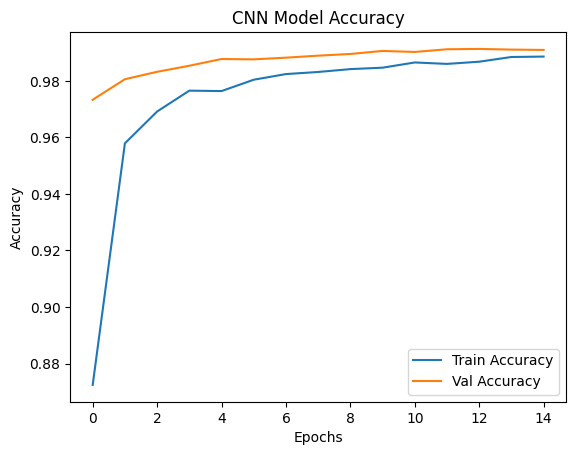

In [30]:
# Plot training and validation accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

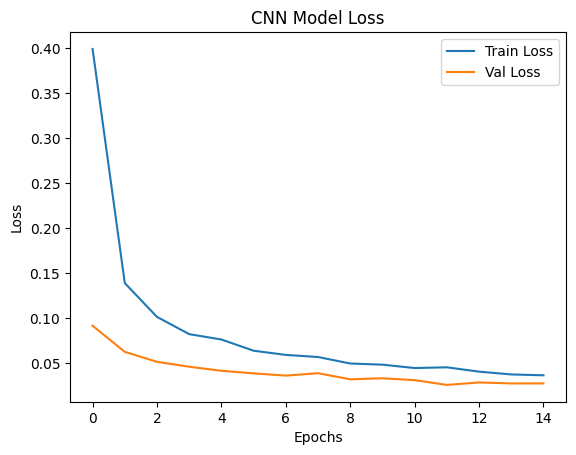

In [31]:
# Plot training and validation loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Visualize some predictions
predictions = cnn_model.predict(test_data)
predictions = np.argmax(predictions, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


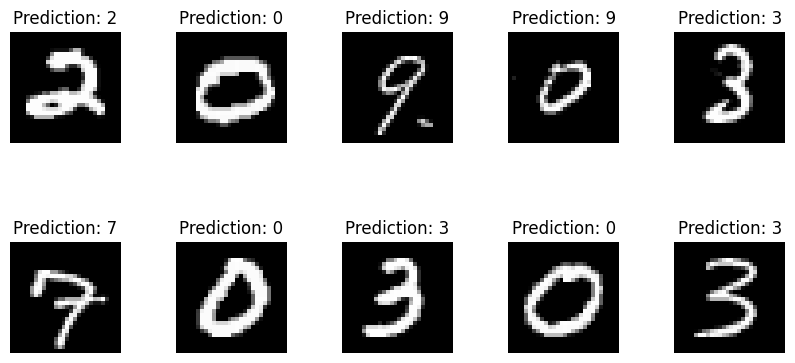

In [33]:
# Display some test images with their predicted labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in np.arange(0, 10):
    axes[i].imshow(test_data[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Prediction: {predictions[i]}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)
plt.show()

### Machine Learning Alogrithm - Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Flatten the image data for Random Forest
X_flat = X.reshape(-1, 28*28)
X_test_flat = test_data.reshape(-1, 28*28)

In [35]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_flat, np.argmax(y, axis=1))

RandomForestClassifier(random_state=42)

In [36]:
# Evaluate the model on the validation set
y_val_pred = rf_model.predict(X_val.reshape(-1, 28*28))
val_acc_rf = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation accuracy for Random Forest: {val_acc_rf}")

Validation accuracy for Random Forest: 1.0


### Submission File Generation

In [37]:
# Generate predictions for the test set using CNN
cnn_predictions = cnn_model.predict(test_data)
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Create the submission file
submission_df = pd.DataFrame({
    'ImageId': np.arange(1, len(cnn_predictions) + 1),
    'Label': cnn_predictions
})
submission_df.to_csv('cnn_submission.csv', index=False)

# Generate predictions for the test set using Random Forest
rf_predictions = rf_model.predict(X_test_flat)

# Create the submission file
submission_df_rf = pd.DataFrame({
    'ImageId': np.arange(1, len(rf_predictions) + 1),
    'Label': rf_predictions
})

submission_df_rf.to_csv('rf_submission.csv', index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
